In [165]:
#import libraries that are used in the code below
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms as tvt
from PIL import Image
import numpy as np
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import random
import time
import numpy
import cv2
from pycocotools.coco import COCO

In [124]:
#setting seed value for reproducibility
# The code is Borrowed from Dr. Avinash Kak's DL Studio Module
seed = 63
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmarks=False
os.environ["PYTHONHASHSEED"] = str(seed)

In [1]:
#Created a subset of the COCO dataset for image classification, focusing on specific classes ('boat', 'cake', 'couch', 'dog', 'motorcycle')
# Path to the COCO annotations file
coco_ann_file = '/Users/skose/Downloads/CocoDataset/annotations/instances_train2017.json'

# Initialize COCO API
coco = COCO(coco_ann_file)

# Output directory for saving the new image classification subset of COCO dataset
output_dir = '/Users/skose/Downloads/CocoSubset'
os.makedirs(output_dir, exist_ok=True)

# Desired classes for image classification as mentioned in Homework 4
desired_classes = ['boat', 'cake', 'couch', 'dog', 'motorcycle']

# Create directories for each class in the output directory
for label in desired_classes:
    class_train_dir = os.path.join(output_dir, 'train', label)
    os.makedirs(class_train_dir, exist_ok=True)
    class_val_dir = os.path.join(output_dir, 'val', label)
    os.makedirs(class_val_dir, exist_ok=True)

# Counters for tracking the number of training and validation images
train_counter = {label: 0 for label in desired_classes}
val_counter = {label: 0 for label in desired_classes}

# Iterate through all images in the COCO dataset
for img_id in coco.getImgIds():
    img_info = coco.loadImgs(img_id)
    img_path = os.path.join('/Users/skose/Downloads/CocoDataset/train2017', img_info[0]['file_name'])

    # Get annotations for the image
    ann_ids = coco.getAnnIds(imgIds=img_id)
    annotations = coco.loadAnns(ann_ids)

    # Check for annotations that matches the desired classes
    matching_classes = set()  #set for containing the names of classes (included only once) for annotations associated with the current image
    for ann in annotations:
        category_id = ann['category_id']
        category_info = coco.loadCats(category_id)[0]
        category_name = category_info['name']
        matching_classes.add(category_name)

    for label in matching_classes:
        if label in desired_classes:
            # Loading and resizing the image using OpenCV
            image = cv2.imread(img_path)
            resized_image = cv2.resize(image, (64, 64)) #64x64 size image as asked in the homework

            # Saving the resized image using PIL
            pil_image = Image.fromarray(resized_image)

            # Determine whether to use the image for training or validation
            if train_counter[label] < 1600: #1600 training images required
                pil_image.save(os.path.join(output_dir, 'train', label, img_info[0]['file_name']))
                train_counter[label] += 1
            elif val_counter[label] < 400:  #400 validation images required
                pil_image.save(os.path.join(output_dir, 'val', label, img_info[0]['file_name']))
                val_counter[label] += 1

            # Break the loop if the required number of images is reached for all classes
            if all(train_counter[label] == 1600 and val_counter[label] == 400 for label in desired_classes):
                break

    # Break the loop if the required number of images is reached for all classes
    if all(train_counter[label] == 1600 and val_counter[label] == 400 for label in desired_classes):
        break


loading annotations into memory...
Done (t=12.02s)
creating index...
index created!


In [5]:
#Custom dataset class for image classification using COCO subset dataset
class MyCocoDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.file_names = []  #storing filename paths for images and associated labels
        self.classes = ['boat', 'cake', 'couch', 'dog', 'motorcycle']
        self.transform = tvt.Compose([
            tvt.ToTensor(),
            tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        for label in self.classes:
            folder_path = os.path.join(root, label)
            for image_file in os.listdir(folder_path):
                info = {'image_path': os.path.join(folder_path, image_file), 'label': self.classes.index(label)} #creating a dictionary to store image path and label for every image
                self.file_names.append(info) #creating a list of dictionary

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        file_name = self.file_names[index]
        image_path = file_name['image_path']

        # Reading image as a PIL image
        image = Image.open(image_path)

        # Applying predefined transform
        augmented_image = self.transform(image)

        # Setting label 
        label = file_name['label']

        return augmented_image, label


In [125]:
#creating instances for train and validation dataset classes
trainDataset = MyCocoDataset('/Users/skose/Downloads/CocoSubset/train') 
valDataset = MyCocoDataset('/Users/skose/Downloads/CocoSubset/val')

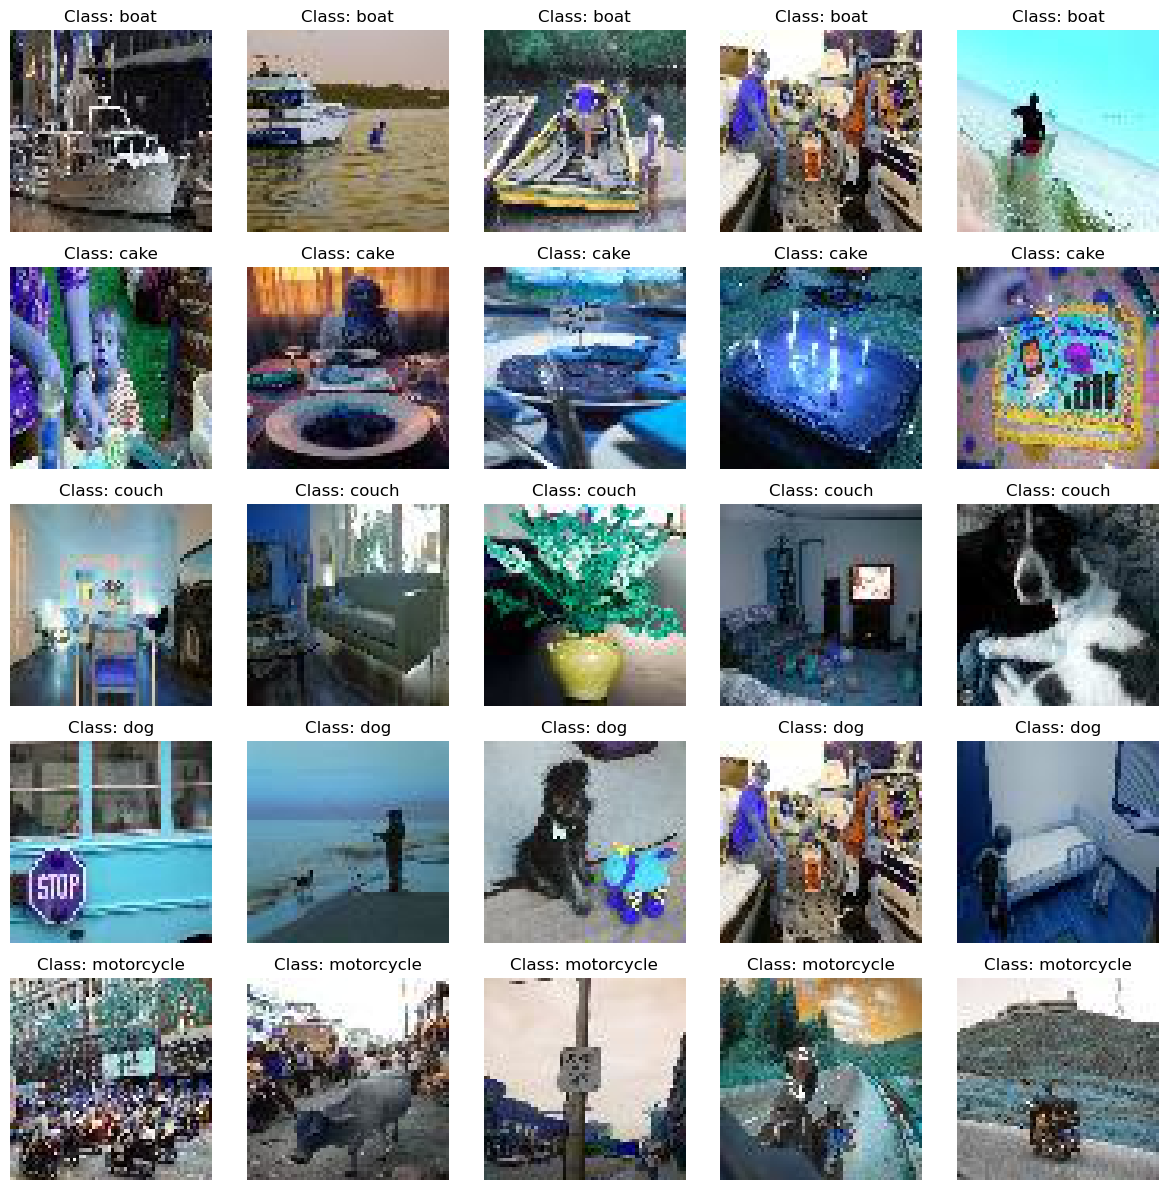

In [126]:
#Plotting 5 images from each of the five classes
import numpy as np

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12))

# Loop through each class
for i, label in enumerate(trainDataset.classes):
    # Filter images of the current class
    class_images = [item for item in trainDataset.file_names if item['label'] == i][:5]

    # Loop through 5 images of the current class
    for j, item in enumerate(class_images):
        image_path = item['image_path']
        label = item['label']

        # Read and display the image
        image = Image.open(image_path)
        axes[i, j].imshow(np.asarray(image))
        axes[i, j].set_title(f'Class: {trainDataset.classes[label]}')

        # Hide axes ticks and labels
        axes[i, j].axis('off')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


In [127]:
#creating instances of Train and validation dataloader
trainDataLoader = DataLoader(trainDataset, batch_size = 4,shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size = 4,shuffle=True)

In [129]:
# The code is derived from Dr. Avinash Kak's DL Studio Module for the training loop
def training_routine(net, epochs, trainDataLoader, device, model_path):
    # Initialize a list to store training losses during each epoch
    training_loss = []
    # Define the loss function (CrossEntropyLoss) and optimizer (Adam)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.99))

    # Move the network to the specified device (CPU or GPU)
    net = net.to(device)

    # Set the network in training mode
    net.train()

    print("Begin Training...\n")

    # Training loop over epochs
    for epoch in range(epochs):
        running_loss = 0.0

        # Iterate over batches in the training data loader
        for i, data in enumerate(trainDataLoader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients to accumulate new gradients
            optimizer.zero_grad()

            # Forward pass: compute predicted outputs by passing inputs through the network
            outputs = net(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Update the parameters (weights) of the model
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            # Print running loss every 100 batches
            if (i + 1) % 100 == 0:
                print("[epoch: %d, batch: %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 100))
                training_loss.append(running_loss / 100)
                running_loss = 0.0

    print("Finished Training!\n")

    # Save the trained model state dictionary to the specified path
    torch.save(net.state_dict(), model_path)

    # Return the list of training losses to plot the loss curve
    return training_loss


In [168]:
#This testing loop derives ideas from the previous year's homework 4 assignment at https://engineering.purdue.edu/DeepLearn/2_best_solutions/2023/Homeworks/HW4/2BestSolutions/1.pdf
def model_evaluation(net, valDataLoader, batch_size, device, desired_classes, model_path):
    # The part of code is derived from Dr. Avinash Kak's DL Studio Module for testing with small changes in it.
    print("Begin...\n")

    # Loading trained model state
    net.load_state_dict(torch.load(model_path))

    # Set the network in evaluation mode
    net.eval()

    # Initialize variables for accuracy calculation
    correct, total = 0, 0

    # Initialize a confusion matrix
    confusion_matrix = torch.zeros(5, 5)

    # Initialize variables for per-class accuracy calculation
    class_correct = [0] * 5
    class_total = [0] * 5

    with torch.no_grad():
        # Iterate over batches in the testing data loader
        for i, data in enumerate(valDataLoader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass: compute predicted outputs by passing inputs through the network
            output = net(inputs)

            # Find the predicted class (index with maximum probability)
            _, predicted = torch.max(output.data, 1)

            # Update total and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update confusion matrix
            comp = predicted == labels
            for label, prediction in zip(labels, predicted):
                confusion_matrix[label][prediction] += 1

            # Update per-class accuracy
            for j in range(batch_size):
                label = labels[j]
                class_correct[label] += comp[j].item()
                class_total[label] += 1
    confusion_matrix_np = confusion_matrix.cpu().numpy()
    # Print per-class accuracy
    for j in range(5):
        print('Prediction accuracy for %5s : %2d %%' % (desired_classes[j], 100 * class_correct[j] / class_total[j]))

    print("Finished!\n")

    # Print overall accuracy
    print('Accuracy of the network on validation images: {}%'.format(100 * float(correct / total)))

    # Return confusion matrix and overall accuracy
    return confusion_matrix_np, float(correct / total)


In [175]:
# Plotting confusion matrix heatmap using matplotlib
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(confusion_matrix, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    class_names = ['boat', 'cake', 'couch', 'dog', 'motorcycle']
    # Set ticks and labels
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Display values in the matrix
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color='black')

    plt.ylabel('Ground Truth Labels')
    plt.xlabel('Predicted Labels')
    plt.show()


In [131]:
#set the device value to the currently used device
if torch.backends.mps.is_available() == True:
 device = torch.device("mps")
else:
 device = torch.device("cpu")
# Print out currently using device
print("Currently using: {}".format(device))

Currently using: mps


In [128]:
#class for Single layer CNN Net1
#implementation is based on the example HW4Net network provided in the homework4 document
class HW4Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3) #Input image size :64x64, Output: (64-3+1) = 62x62
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Input: 62x62, Output: 62/2 = 31x31
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)  # Input: 31x31, Output: (31-3+1) = 29x29
        self.fc1 = nn.Linear(in_features=32 * 14 * 14, out_features=64) # Input: XXXX= 32*14*14 = 6272, Output: 64
        self.fc2 = nn.Linear(in_features=64, out_features=5) # Output: X=5 desired classes
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Input: 64x64, Output: 31x31
        x = self.pool(F.relu(self.conv2(x))) # Input: 31x31, Output: 14x14
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [132]:
#run the training loop and save the training loss for plotting later
net1 = HW4Net1()
epochs_net1 = 15
model_path1=os.path.join('/Users/skose/Downloads/path', 'net11.pth')
training_loss_net1 = training_routine(net1, epochs_net1, trainDataLoader, device, model_path1)

Begin Training...

[epoch: 1, batch:   100] loss: 1.535
[epoch: 1, batch:   200] loss: 1.395
[epoch: 1, batch:   300] loss: 1.377
[epoch: 1, batch:   400] loss: 1.326
[epoch: 1, batch:   500] loss: 1.365
[epoch: 1, batch:   600] loss: 1.308
[epoch: 1, batch:   700] loss: 1.268
[epoch: 1, batch:   800] loss: 1.257
[epoch: 1, batch:   900] loss: 1.258
[epoch: 1, batch:  1000] loss: 1.113
[epoch: 1, batch:  1100] loss: 1.231
[epoch: 1, batch:  1200] loss: 1.189
[epoch: 1, batch:  1300] loss: 1.266
[epoch: 1, batch:  1400] loss: 1.220
[epoch: 1, batch:  1500] loss: 1.112
[epoch: 1, batch:  1600] loss: 1.103
[epoch: 1, batch:  1700] loss: 1.131
[epoch: 1, batch:  1800] loss: 1.124
[epoch: 1, batch:  1900] loss: 1.136
[epoch: 1, batch:  2000] loss: 1.058
[epoch: 2, batch:   100] loss: 1.008
[epoch: 2, batch:   200] loss: 1.064
[epoch: 2, batch:   300] loss: 1.084
[epoch: 2, batch:   400] loss: 1.027
[epoch: 2, batch:   500] loss: 1.065
[epoch: 2, batch:   600] loss: 1.002
[epoch: 2, batch:  

In [171]:
#run the evaluation on validation dataset and save the validation accuracy and confusion matrix 
batch_size1=4
confusion_matrix_net1, validation_acc_net1 = model_evaluation(net1, valDataLoader, batch_size1, device, desired_classes,model_path1)

Begin...

Prediction accuracy for  boat : 56 %
Prediction accuracy for  cake : 47 %
Prediction accuracy for couch : 52 %
Prediction accuracy for   dog : 41 %
Prediction accuracy for motorcycle : 60 %
Finished!

Accuracy of the network on validation images: 51.849999999999994%


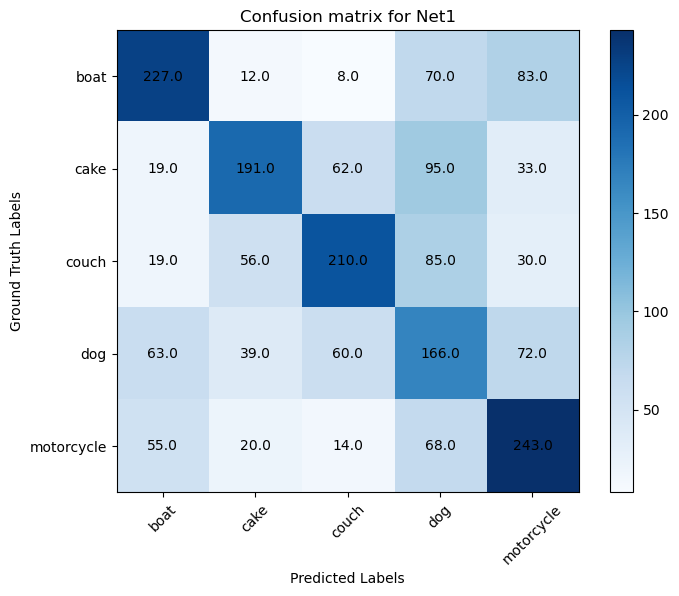

In [174]:
#Plot confusion matrix 
title= 'Confusion matrix for Net1'
plot_confusion_matrix(confusion_matrix_net1, title)

In [141]:
#class for Single layer CNN Net2
class HW4Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,padding=1)
        self.fc1 = nn.Linear(in_features=32 * 16 * 16, out_features=64) # Input: XXXX= 32*16*16 = 8192, Output: 64
        self.fc2 = nn.Linear(in_features=64, out_features=5) # Output: X=5 desired classes
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Output Size: (64 - 3 + 2*1)/1 + 1 = 64; After Max Pooling: 32x32
        x = self.pool(F.relu(self.conv2(x))) # Output Size: (32 - 3 + 2*1)/1 + 1 = 32; After Max Pooling: 16x16
        x = x.view(x.shape[0], -1) #Flattened Output Size: 32 * 16 * 16
        x = F.relu(self.fc1(x)) # Output Size: 64
        x = self.fc2(x)   # Output Size: 5 (for 5 classes)
        return x

In [263]:
#run the training loop and save the training loss for plotting later
net2 = HW4Net2()
epochs_net2 = 15  # Number of training epochs
model_path2 = os.path.join('/Users/skose/Downloads/path', 'net21.pth')  # Path to save the trained model
training_loss_net2 = training_routine(net2, epochs_net2, trainDataLoader, device, model_path2)

Begin Training...

[epoch: 1, batch:   100] loss: 1.591
[epoch: 1, batch:   200] loss: 1.419
[epoch: 1, batch:   300] loss: 1.340
[epoch: 1, batch:   400] loss: 1.255
[epoch: 1, batch:   500] loss: 1.233
[epoch: 1, batch:   600] loss: 1.184
[epoch: 1, batch:   700] loss: 1.187
[epoch: 1, batch:   800] loss: 1.185
[epoch: 1, batch:   900] loss: 1.180
[epoch: 1, batch:  1000] loss: 1.183
[epoch: 1, batch:  1100] loss: 1.163
[epoch: 1, batch:  1200] loss: 1.085
[epoch: 1, batch:  1300] loss: 1.232
[epoch: 1, batch:  1400] loss: 1.126
[epoch: 1, batch:  1500] loss: 1.160
[epoch: 1, batch:  1600] loss: 1.097
[epoch: 1, batch:  1700] loss: 1.141
[epoch: 1, batch:  1800] loss: 1.185
[epoch: 1, batch:  1900] loss: 1.177
[epoch: 1, batch:  2000] loss: 1.117
[epoch: 2, batch:   100] loss: 1.057
[epoch: 2, batch:   200] loss: 1.019
[epoch: 2, batch:   300] loss: 1.114
[epoch: 2, batch:   400] loss: 1.077
[epoch: 2, batch:   500] loss: 1.003
[epoch: 2, batch:   600] loss: 1.076
[epoch: 2, batch:  

In [264]:
#run the evaluation on validation dataset and save the validation accuracy and confusion matrix 
batch_size2 = 4  
confusion_matrix_net2, validation_acc_net2 = model_evaluation(net2, valDataLoader, batch_size2, device, desired_classes, model_path2)

Begin...

Prediction accuracy for  boat : 67 %
Prediction accuracy for  cake : 57 %
Prediction accuracy for couch : 58 %
Prediction accuracy for   dog : 33 %
Prediction accuracy for motorcycle : 49 %
Finished!

Accuracy of the network on validation images: 53.1%


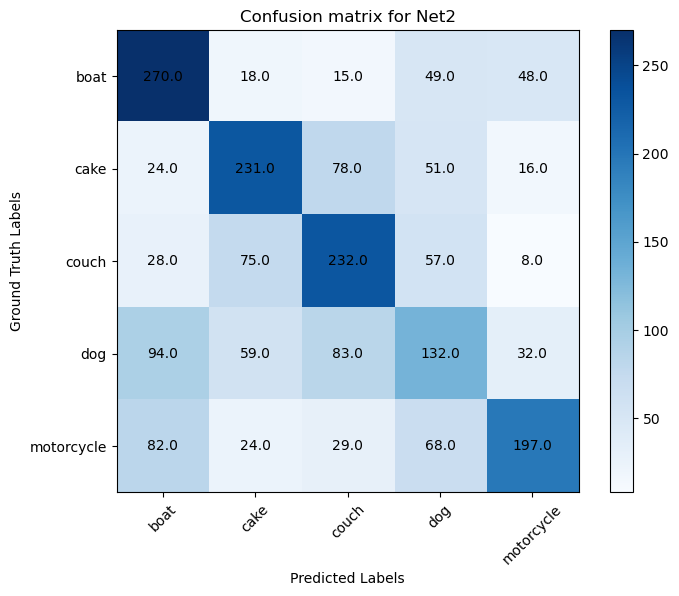

In [265]:
#Plot confusion matrix 
title= 'Confusion matrix for Net2'
plot_confusion_matrix(confusion_matrix_net2, title)

In [186]:
#class for CNN Network with 10 additional convolutional layer Net3
class HW4Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # List of 10 Consecutive Convolutional Layers
        self.conv_layers = nn.ModuleList([nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1) for _ in range(10)])
        self.fc1 = nn.Linear(in_features=32 * 16 * 16, out_features=64)  # Input: XXXX= 32*16*16 = 8192, Output: 64
        self.fc2 = nn.Linear(in_features=64, out_features=5)  # Output: X=5 desired classes
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Output Size: (64 - 3 + 2*1)/1 + 1 = 64; After Max Pooling: 32x32
        x = self.pool(F.relu(self.conv2(x))) # Output Size: (32 - 3 + 2*1)/1 + 1 = 32; After Max Pooling: 16x16
        # Consecutive Convolutional Layers in the List
        for m in self.conv_layers:
            x = F.relu(m(x))  # Output Size: 16x16 for each layer
        x = x.view(x.shape[0], -1) # Flattened Output Size: 32 * 16 * 16
        x = F.relu(self.fc1(x)) # Output Size: 64
        x = self.fc2(x)    # Output Size: 5 (for 5 classes)
        return x

In [260]:
#run the training loop and save the training loss for plotting later
net3 = HW4Net3()
epochs_net3 = 15
save_path_net3 = os.path.join('/Users/skose/Downloads/path', 'net3.pth')
training_loss_net3 = training_routine(net3, epochs_net3, trainDataLoader, device, save_path_net3)

Begin Training...

[epoch: 1, batch:   100] loss: 1.614
[epoch: 1, batch:   200] loss: 1.606
[epoch: 1, batch:   300] loss: 1.614
[epoch: 1, batch:   400] loss: 1.612
[epoch: 1, batch:   500] loss: 1.612
[epoch: 1, batch:   600] loss: 1.609
[epoch: 1, batch:   700] loss: 1.609
[epoch: 1, batch:   800] loss: 1.612
[epoch: 1, batch:   900] loss: 1.609
[epoch: 1, batch:  1000] loss: 1.613
[epoch: 1, batch:  1100] loss: 1.610
[epoch: 1, batch:  1200] loss: 1.610
[epoch: 1, batch:  1300] loss: 1.610
[epoch: 1, batch:  1400] loss: 1.610
[epoch: 1, batch:  1500] loss: 1.610
[epoch: 1, batch:  1600] loss: 1.610
[epoch: 1, batch:  1700] loss: 1.610
[epoch: 1, batch:  1800] loss: 1.609
[epoch: 1, batch:  1900] loss: 1.610
[epoch: 1, batch:  2000] loss: 1.610
[epoch: 2, batch:   100] loss: 1.610
[epoch: 2, batch:   200] loss: 1.611
[epoch: 2, batch:   300] loss: 1.610
[epoch: 2, batch:   400] loss: 1.609
[epoch: 2, batch:   500] loss: 1.611
[epoch: 2, batch:   600] loss: 1.609
[epoch: 2, batch:  

In [261]:
#run the evaluation on validation dataset and save the validation accuracy and confusion matrix 
batch_size_net3 = 4
confusion_matrix_net3, testing_acc_net3 = model_evaluation(net3, valDataLoader, batch_size_net3, device, desired_classes, save_path_net3)

Begin...

Prediction accuracy for  boat :  0 %
Prediction accuracy for  cake : 100 %
Prediction accuracy for couch :  0 %
Prediction accuracy for   dog :  0 %
Prediction accuracy for motorcycle :  0 %
Finished!

Accuracy of the network on validation images: 20.0%


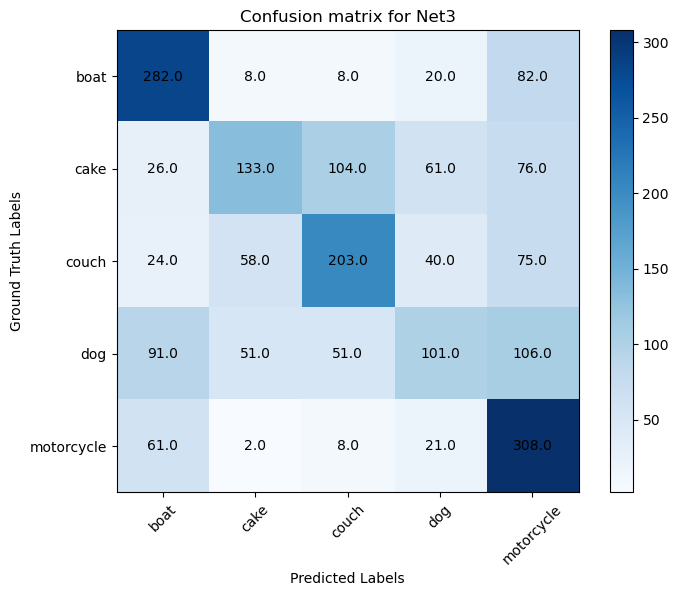

In [185]:
#Plot confusion matrix 
title= 'Confusion matrix for Net3'
plot_confusion_matrix(confusion_matrix_net3, title)

In [199]:
#class for CNN Network with 10 additional convolutional layer Net3 using leaky ReLu instead of ReLu, to address the problem of vanishing gradient descent
class HW4Net31(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # List of 10 Consecutive Convolutional Layers
        self.conv_layers = nn.ModuleList([nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1) for _ in range(10)])
        self.fc1 = nn.Linear(in_features=32 * 16 * 16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=5)
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.conv2(x), negative_slope=0.01))
        for m in self.conv_layers:
            x = F.leaky_relu(m(x), negative_slope=0.01)
        x = x.view(x.shape[0], -1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.fc2(x)
        return x

In [201]:
#run the training loop and save the training loss for plotting later
net6 = HW4Net31()
epochs_net6 = 15
save_path6 = os.path.join('/Users/skose/Downloads/path', 'net31.pth')
training_loss_net6 = training_routine(net6, epochs_net6, trainDataLoader, device, save_path6)

Begin Training...

[epoch: 1, batch:   100] loss: 1.623
[epoch: 1, batch:   200] loss: 1.613
[epoch: 1, batch:   300] loss: 1.608
[epoch: 1, batch:   400] loss: 1.613
[epoch: 1, batch:   500] loss: 1.611
[epoch: 1, batch:   600] loss: 1.614
[epoch: 1, batch:   700] loss: 1.613
[epoch: 1, batch:   800] loss: 1.610
[epoch: 1, batch:   900] loss: 1.610
[epoch: 1, batch:  1000] loss: 1.611
[epoch: 1, batch:  1100] loss: 1.615
[epoch: 1, batch:  1200] loss: 1.618
[epoch: 1, batch:  1300] loss: 1.613
[epoch: 1, batch:  1400] loss: 1.609
[epoch: 1, batch:  1500] loss: 1.610
[epoch: 1, batch:  1600] loss: 1.612
[epoch: 1, batch:  1700] loss: 1.611
[epoch: 1, batch:  1800] loss: 1.612
[epoch: 1, batch:  1900] loss: 1.610
[epoch: 1, batch:  2000] loss: 1.672
[epoch: 2, batch:   100] loss: 1.616
[epoch: 2, batch:   200] loss: 1.611
[epoch: 2, batch:   300] loss: 1.611
[epoch: 2, batch:   400] loss: 1.611
[epoch: 2, batch:   500] loss: 1.613
[epoch: 2, batch:   600] loss: 1.610
[epoch: 2, batch:  

Begin...

Prediction accuracy for  boat : 57 %
Prediction accuracy for  cake : 76 %
Prediction accuracy for couch : 54 %
Prediction accuracy for   dog : 30 %
Prediction accuracy for motorcycle : 60 %
Finished!

Accuracy of the network on validation images: 55.85%


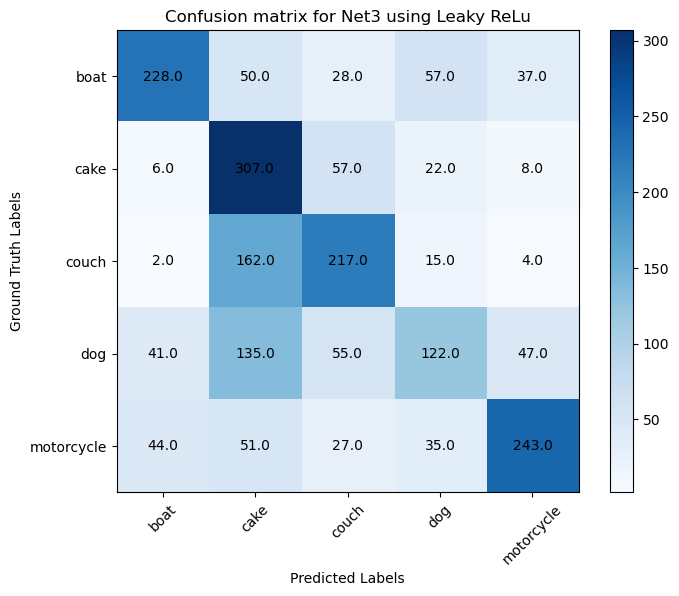

In [258]:
#run the evaluation on validation dataset and save the validation accuracy and confusion matrix 
batch_size_net6 = 4
confusion_matrix_net6, testing_acc_net6 = model_evaluation(net6, valDataLoader, batch_size_net6, device, desired_classes, save_path6)
#Plot confusion matrix 
title= 'Confusion matrix for Net3 using Leaky ReLu'
plot_confusion_matrix(confusion_matrix_net6, title)

In [238]:
#function to plot the training loss curve for the three networks
def train_loss_plot(train_loss, title):
    plt.plot(train_loss[0], 'r', label='Convolutional Network Net1')
    plt.plot(train_loss[1], 'b', label='Convolutional Network with Padding Net2')
    plt.plot(train_loss[2], 'g', label='Convolutional Network Extra 10 Layers Net3')
    plt.title(title)
    plt.legend(loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()


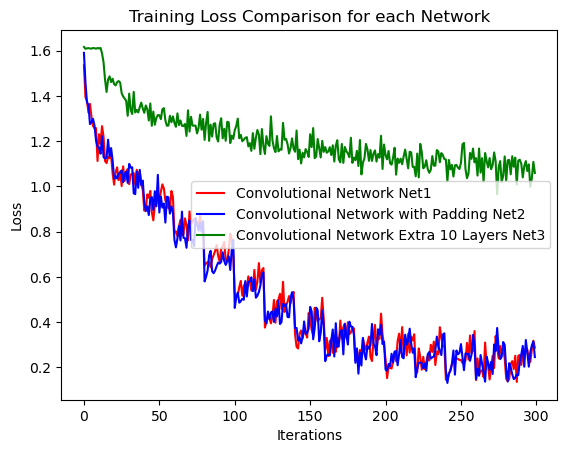

In [247]:
train_loss = []
train_loss.append(training_loss_net1)
train_loss.append(training_loss_net2)
train_loss.append(training_loss_net3)
train_loss_plot(train_loss, 'Training Loss Comparison for each Network')

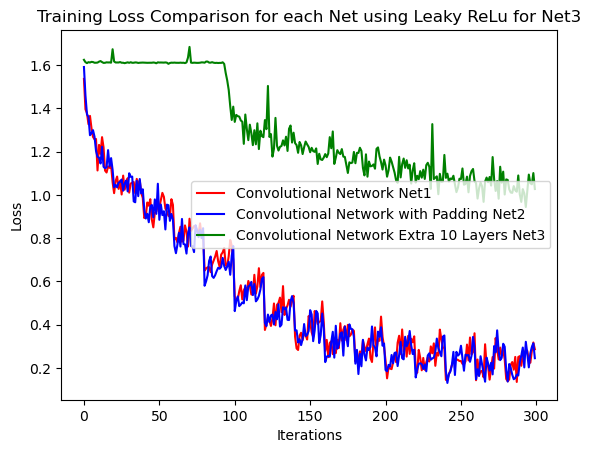

In [248]:
train_loss = []
train_loss.append(training_loss_net1)
train_loss.append(training_loss_net2)
train_loss.append(training_loss_net6)
train_loss_plot(train_loss, 'Training Loss Comparison for each Net using Leaky ReLu for Net3')

In [222]:
#function to count the total number of parameters for a network
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

In [223]:
#total number of parameters for a Net1
total_parameters = count_parameters(net1)
print(f"Total parameters in the Net1 model: {total_parameters}")

Total parameters in the Net1 model: 406885


In [224]:
#total number of parameters for a Net2
total_parameters = count_parameters(net2)
print(f"Total parameters in the Net2 model: {total_parameters}")

Total parameters in the Net2 model: 529765


In [225]:
#total number of parameters for a Net3
total_parameters = count_parameters(net3)
print(f"Total parameters in the Net3 model: {total_parameters}")

Total parameters in the Net3 model: 622245
